In [1]:
#!/usr/bin/python3
import numpy as np
from math import exp
from numpy.random import binomial,shuffle,seed, choice
import pandas as pd
from IPython.display import display, clear_output
import os
import CompactLSM

seedval =15 # for replicating results (used for 2,3,6,7,11

Reservoir Dimension set

In [2]:
nx = 5
ny = 5
nz = 5
N = nx*ny*nz                                          # Reservoir size

N_read = 10                                           # No. of Readout neurons

Important constants related to LIF neuron and synaptic model

In [3]:
global vrest, vth, t_refrac
vrest, vth, t_refrac = 0, 20, 2

tau_m = 32
params_potential = {'C':1, 'g_L':1/tau_m, 'E_L':vrest, 'V_T':vth, 'R_p':t_refrac}

Delay = 1 #constant delay for all synapses in ms

tau_c = 64
C_theta = 5
del_C = 3
n_bits = 8
delta_c = 1
params_conc = {'C_theta':C_theta, 'del_C':del_C, 'tau_c':64, 'nbits':n_bits, 'delta_c':delta_c}

syn_string = "second-order"

sampling_freq = 12.5 # in khz
h = 1 # in ms
α_w = 0.8
time_params = {'h':h, 'Delay':Delay}

Set Reservoir Connections

In [4]:
# Storing the IDs of the neurons
LSM_ID = np.zeros((nx,ny,nz),dtype=np.int64)
l = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            LSM_ID[i,j,k] = l
            l = l + 1

# Storing the synapse connections, and creating the initial weight matrix

k_prob = [0.45, 0.3, 0.6, 0.15]
r_sq = 2**2

W_arr = [3, 6, -2, -2]
W_init = 3
Weights_temp = np.zeros((N,N))

N_in = int(N*0.8)
neuron_type = [ int(i<N_in) for i in range(N)]
seed(seedval)
shuffle(neuron_type) # 1 for excitatory, 0 for inhibitory

synapes = [dict() for i in range(N)]    # an array of dictonaries which store the location of neuron, 
                                        # type of neuron, and the IDs of the neurons it is connected to

for l in range(N):
    loc = CompactLSM.ID_to_ind(nx,ny,nz,l)
    n_type = neuron_type[l]
    cons = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if l != int(LSM_ID[i,j,k]):
                    dist_sq = (loc[0]-i)**2 + (loc[1]-j)**2 + (loc[2]-k)**2
                    k_probl = 0
                    if n_type == 1:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[0]
                        W_init = W_arr[0]
                      else:
                        k_probl = k_prob[1]
                        W_init = W_arr[1]
                    else:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[2]
                        W_init = W_arr[2]
                      else:
                        k_probl = k_prob[3]
                        W_init = W_arr[3]

                    probability = k_probl* exp(-1*dist_sq/r_sq)
#                     print(probability)
                    check = binomial(1,probability)
                    if check == 1:
                        cons.append(int(LSM_ID[i,j,k]))
                        Weights_temp[l,int(LSM_ID[i,j,k])] = W_init    
    synapes[l] = {"Location":loc, "Neuron_type":n_type, "connections":cons}

global Weights
Weights = Weights_temp * α_w
print("Total synapse:", len(np.argwhere(Weights!=0)), 
        ",E --> E :", len(np.argwhere(Weights==W_arr[0] * α_w)), 
        ",E --> I:",len(np.argwhere(Weights==W_arr[1] * α_w)),
        ",I --> E/I:",len(np.argwhere(Weights==W_arr[2] * α_w)))
i = 64
print("Total Connections: for neuron {}:{}, {}".format(i,synapes[i]["Neuron_type"],synapes[i]["connections"]) )
Weights[1,2]

Total synapse: 1115 ,E --> E : 724 ,E --> I: 121 ,I --> E/I: 270
Total Connections: for neuron 64:1, [7, 33, 38, 58, 61, 67, 69, 74, 78, 83, 98, 107, 118, 119, 122]


0.0

Set Readout neuron initial Weights

In [5]:
All_labels = [str(x) for x in range(10)]
# N_read = 10                                           # No. of Readout neurons

Weights_temp_readOut = -8 + 16 * np.random.rand(N_read, N) # random weight initialization


synapes_read = []        # an array of dictonaries which store the label of neuron, 
                                                      # and the IDs of the neurons it is connected to

for l in range(N_read):
    label = All_labels[l]
    synapes_read.append(label)

Weights_readOut = Weights_temp_readOut

In [6]:
# creating file location and label arrays for train and validate

base = 'PreProcessing/trainBSA'
os.listdir(base)

All_Labels = []
file_name_List = []

for human in os.listdir(base):
    base_up = base + '/' + human
    for train_sample in os.listdir(base_up):
        train_Label = train_sample[0:2]
        file_loc = base_up + '/' + train_sample
        file_name_List.append(file_loc)
        All_Labels.append(train_Label)

In [7]:
L = 78
Fin = 4
reservoir_ID = [i for i in range(N)]
seed(seedval)
Input_CXNs = choice(reservoir_ID, size = (L,Fin))
sign_win_matrix = (binomial(1,1/2, size = (L, Fin)) - 0.5)*2
# Input_CXNs * sign_win_matrix

### Finding input neurons to reservoir current and then using the spike train to find the current input to the reservoir

In [8]:
# print("Input neurons =",L)
print("Size of Reservoir =",nx,"X",ny,"X",nz,",Total total neurons =",N)
print("Total no.of read out neurons =",N_read)

Size of Reservoir = 5 X 5 X 5 ,Total total neurons = 125
Total no.of read out neurons = 10


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (6.4 * 2, 4.8 * 2),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)

### Network Learning with different synaptic configurations

In [10]:
syn_string = "static"

[LibSVM]Training Completed 

Validation Completed 

Accuracy:91.66666666666666


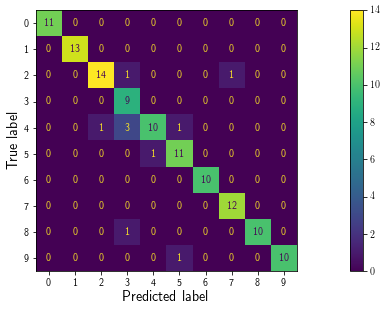

In [11]:
############### Training ###################
Input_gen_func = CompactLSM.Input_current_gen(file_name_List,
                                                syn_string,
                                                N,
                                                time_params,
                                                Input_CXNs,
                                                sign_win_matrix,
                                                training=True,
                                                train_Labels=All_Labels)
NUM_INPUTS = len(All_Labels)

X = np.zeros((NUM_INPUTS,N))
Y = np.zeros((NUM_INPUTS,))

for i in range(NUM_INPUTS):
    In_app, L, M, Label, input_num, In_spikes = next(
        Input_gen_func)  # Generates next input

    [Reservoir_potential, Reservoir_Spikes
        ] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app,
                                        params_potential, Weights, syn_string)
    

    X[i,:] = np.sum(Reservoir_Spikes,axis=1)
    Y[i] = Label

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seedval)

#Create a svm Classifier
clf = svm.SVC(kernel='linear', verbose=True, tol=1e-10) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

print('Training Completed \n')

#Predict the response for test dataset
Y_pred = clf.predict(X_val)


Acc = accuracy_score(Y_val, Y_pred)

print('Validation Completed \n')

display_string = "Accuracy:{}".format(Acc * 100)
print(display_string)

cm_validate = confusion_matrix(Y_val,
                                   Y_pred,
                                   labels=[i for i in range(10)])
disp_validate = ConfusionMatrixDisplay(
    confusion_matrix=cm_validate, display_labels=[i for i in range(10)])
disp_validate.plot();
plt.show()

In [12]:
syn_string = "first-order"

[LibSVM]Training Completed 

Validation Completed 

Accuracy:93.33333333333333


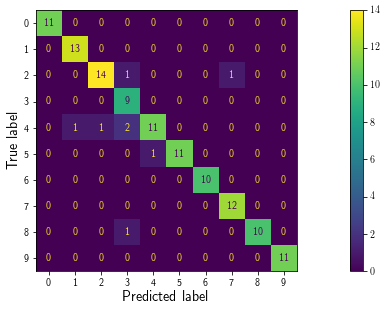

In [13]:
############### Training ###################
Input_gen_func = CompactLSM.Input_current_gen(file_name_List,
                                                syn_string,
                                                N,
                                                time_params,
                                                Input_CXNs,
                                                sign_win_matrix,
                                                training=True,
                                                train_Labels=All_Labels)
NUM_INPUTS = len(All_Labels)

X = np.zeros((NUM_INPUTS,N))
Y = np.zeros((NUM_INPUTS,))

for i in range(NUM_INPUTS):
    In_app, L, M, Label, input_num, In_spikes = next(
        Input_gen_func)  # Generates next input

    [Reservoir_potential, Reservoir_Spikes
        ] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app,
                                        params_potential, Weights, syn_string)
    

    X[i,:] = np.sum(Reservoir_Spikes,axis=1)
    Y[i] = Label

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seedval)

#Create a svm Classifier
clf = svm.SVC(kernel='linear', verbose=True, tol=1e-10) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

print('Training Completed \n')

#Predict the response for test dataset
Y_pred = clf.predict(X_val)


Acc = accuracy_score(Y_val, Y_pred)

print('Validation Completed \n')

display_string = "Accuracy:{}".format(Acc * 100)
print(display_string)

cm_validate = confusion_matrix(Y_val,
                                   Y_pred,
                                   labels=[i for i in range(10)])
disp_validate = ConfusionMatrixDisplay(
    confusion_matrix=cm_validate, display_labels=[i for i in range(10)])
disp_validate.plot();
plt.show()

In [14]:
syn_string = "second-order"

[LibSVM]Training Completed 

Validation Completed 

Accuracy:92.5


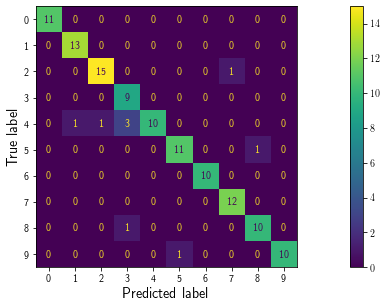

In [15]:
############### Training ###################
Input_gen_func = CompactLSM.Input_current_gen(file_name_List,
                                                syn_string,
                                                N,
                                                time_params,
                                                Input_CXNs,
                                                sign_win_matrix,
                                                training=True,
                                                train_Labels=All_Labels)
NUM_INPUTS = len(All_Labels)

X = np.zeros((NUM_INPUTS,N))
Y = np.zeros((NUM_INPUTS,))

for i in range(NUM_INPUTS):
    In_app, L, M, Label, input_num, In_spikes = next(
        Input_gen_func)  # Generates next input

    [Reservoir_potential, Reservoir_Spikes
        ] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app,
                                        params_potential, Weights, syn_string)
    

    X[i,:] = np.sum(Reservoir_Spikes,axis=1)
    Y[i] = Label

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seedval)

#Create a svm Classifier
clf = svm.SVC(kernel='linear', verbose=True, tol=1e-10) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

print('Training Completed \n')

#Predict the response for test dataset
Y_pred = clf.predict(X_val)


Acc = accuracy_score(Y_val, Y_pred)

print('Validation Completed \n')

display_string = "Accuracy:{}".format(Acc * 100)
print(display_string)

cm_validate = confusion_matrix(Y_val,
                                   Y_pred,
                                   labels=[i for i in range(10)])
disp_validate = ConfusionMatrixDisplay(
    confusion_matrix=cm_validate, display_labels=[i for i in range(10)])
disp_validate.plot();
plt.show()

### Network Learning without reservoir, only input spikes

[LibSVM]Training Completed 

Validation Completed 

Accuracy:91.66666666666666


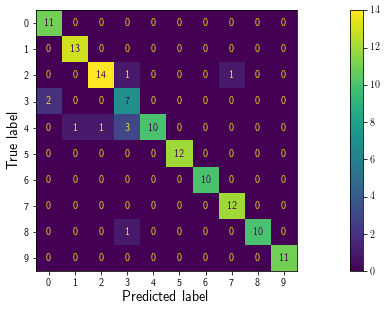

In [16]:
############### Training ###################
Input_gen_func = CompactLSM.Input_current_gen(file_name_List,
                                                syn_string,
                                                N,
                                                time_params,
                                                Input_CXNs,
                                                sign_win_matrix,
                                                training=True,
                                                train_Labels=All_Labels)
NUM_INPUTS = len(All_Labels)

X = np.zeros((NUM_INPUTS,78))
Y = np.zeros((NUM_INPUTS,))

for i in range(NUM_INPUTS):
    In_app, L, M, Label, input_num, In_spikes = next(
        Input_gen_func)  # Generates next input
    

    X[i,:] = np.sum(In_spikes,axis=1)
    Y[i] = Label

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seedval)

#Create a svm Classifier
clf = svm.SVC(kernel='linear', verbose=True, tol=1e-10) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

print('Training Completed \n')

#Predict the response for test dataset
Y_pred = clf.predict(X_val)


Acc = accuracy_score(Y_val, Y_pred)

print('Validation Completed \n')

display_string = "Accuracy:{}".format(Acc * 100)
print(display_string)

cm_validate = confusion_matrix(Y_val,
                                   Y_pred,
                                   labels=[i for i in range(10)])
disp_validate = ConfusionMatrixDisplay(
    confusion_matrix=cm_validate, display_labels=[i for i in range(10)])
disp_validate.plot();
plt.show()